## Cross-section plots of continental vs. glacial river contributions 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
from itertools import compress
import datetime as dt
from matplotlib.colors import ListedColormap
from math import sin, cos, sqrt, atan2, radians
import xarray as xr

%matplotlib inline

##### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

month = 8

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Time series folders:
folder_ts_ref  = '/ocean/brogalla/GEOTRACES/time-series/Mn-reference-202110/'
folder_ts_glac = '/ocean/brogalla/GEOTRACES/time-series/river-glacial-202112/'
folder_ts_cont = '/ocean/brogalla/GEOTRACES/time-series/river-continental-202112/'

# Boundary coordinates:
xmin=imin+1; ymin=jmin+1;
r1i = 1520-xmin;                      r1j = np.arange(505-ymin,673-ymin)
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares
P1i = 1585-xmin;                      P1j = np.arange(485-ymin,538-ymin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]
P2i = 1664-xmin;                      P2j = np.arange(465-ymin,490-ymin);

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

vals_both = np.ones((N, 4))
vals_both[:, 0] = np.linspace(89/N, 1, N); 
vals_both[:, 1] = np.linspace(89/N, 1, N)
vals_both[:, 2] = np.linspace(89/N, 1, N)
both_cmap = ListedColormap(vals_both).reversed()

##### Load files:

In [3]:
# Meshmasks
mask          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mask.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mask.variables['nav_lon'])
lat_ANHA12    = np.array(mask.variables['nav_lat'])

In [4]:
ref     = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2002_20211012/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub = np.array(ref.variables['nav_lon'])
lat_sub = np.array(ref.variables['nav_lat'])
depth   = np.array(ref.variables['deptht'])

##### Functions:

In [5]:
def load_Mn_prop_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
    
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    glacier_prop     = calculate_prop(dmn_ref, dmn_glac)
    continental_prop = calculate_prop(dmn_ref, dmn_cont)
    
    return glacier_prop, continental_prop

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*2*100 # times 2 so that full contribution from rivers is 100%
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [7]:
def time_series_pickle(year):
    # Load calculated time series of fluxes:
    time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
    time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
    time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
    time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder_ts_ref}time-series-{year}.pickle','rb'))
    
    # Conservation of volume check:
    sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
           (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
    
    # Combine western CAA time series:
    time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)
    
    return time_series_V1, time_series_V2, time_series_V_WCAA, time_series_V7, time_series_V8, \
            time_series_V9, time_series_V10, time_series_V11

In [8]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1E = np.sort(os.listdir(f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-{year}_20211012/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [9]:
def calc_distance(i,j):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lat_sub[i,j]]
    lons_rad = [radians(l) for l in lon_sub[i,j]]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

##### Calculations:

In [11]:
glacier_prop, continental_prop = load_Mn_prop_results()

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


### Figures

Cross sections:

In [52]:
# Load volume fluxes:
ts_V1, ts_V2, ts_V_WCAA, ts_V7, ts_V8, ts_V9, ts_V10, ts_V11 = time_series_pickle(2015)

V08   = np.empty((12, 50, 167)); V10   = np.empty((12, 50, 59)); V11   = np.empty((12, 50, 52));
dates = file_dates(2015)

for months in np.arange(1, 13):
    Volume08 = np.zeros((50,167))
    Volume10 = np.zeros((50,59))
    Volume11 = np.zeros((50,52))
    n = 0
    for i in range(0,len(dates)):
        if dates[i].month == months:
            Volume08 = Volume08 + ts_V8[i,:,:]
            Volume10 = Volume10 + ts_V10[i,:,:]
            Volume11 = Volume11 + ts_V11[i,:,:]
            n+=1
            
    # m3/s
#     V08[months-1] = Volume08/(10000*n)            
#     V10[months-1] = Volume10/(10000*n)
#     V11[months-1] = Volume11/(10000*n)
    # m3/s
    V08[months-1] = Volume08/(n)            
    V10[months-1] = Volume10/(n)
    V11[months-1] = Volume11/(n)

In [53]:
# Mask small values in cross section
ma_glac_xs = np.ma.masked_where((glacier_prop[:,:,:,:] < 0.05), glacier_prop[:,:,:,:])
ma_cont_xs = np.ma.masked_where((continental_prop[:,:,:,:] < glacier_prop[:,:,:,:]), continental_prop[:,:,:,:])
ma_both_xs = ma_cont_xs + ma_glac_xs

# only mask lower values for contour lines:
ma_glac_xs_low = np.ma.masked_where((glacier_prop[:,:,:,:] < 0.05)    , glacier_prop[:,:,:,:])
ma_cont_xs_low = np.ma.masked_where((continental_prop[:,:,:,:] < 0.05), continental_prop[:,:,:,:])
ma_both_xs_low = ma_cont_xs_low + ma_glac_xs_low

# Calculate distance along cross section
distance_PC  = calc_distance(P1i, P1j)
distance_PC2 = calc_distance(P2i, P2j)
distance_NS  = calc_distance(N1i, N1j)
distance_BB  = calc_distance(r1i, r1j)

In [87]:
def transect_PC(axis, month):
    
    vmin_cont = 0; vmax_cont = 0.2;
    vmin_glac = 0; vmax_glac = 8;
    vmin_both = 0; vmax_both = 3;

    # Coloured in contours for river Mn:
    CS1 = axis.pcolormesh(distance_PC, depth, np.transpose(ma_cont_xs_low[month,:,P1i,P1j]), \
                        vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)
    CS2 = axis.pcolormesh(distance_PC, depth, np.transpose(ma_glac_xs_low[month,:,P1i,P1j]), \
                        vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

    # Contour lines for river Mn:
    glac_levels = [1, 2, 3, 4, 5, 6, 7, 8]
    cont_levels = [0.1, 0.15, 0.2]
    glac = axis.contour(distance_PC, depth, np.transpose(ma_glac_xs_low[month,:,P1i,P1j]), \
               levels=glac_levels, colors='#04395a', linewidths=0.7)
    cont = axis.contour(distance_PC, depth, np.transpose(ma_cont_xs_low[month,:,P1i,P1j]), \
               levels=cont_levels, colors='#ab5c29', linewidths=0.7)

    # Volume flux:
    axis.contour(distance_PC, depth, V11[8,:,10:-4], [-400, 400], colors='k', linewidths=0.7)
    
    # Colour bars + figure features:
    cb1axes = fig.add_axes([0.92, 0.78, 0.06, 0.10]) 
    cb2axes = fig.add_axes([0.92, 0.66, 0.06, 0.10]) 
    CBar1 = fig.colorbar(CS1, cax=cb1axes, ticks=[0,0.1,0.2])
    CBar2 = fig.colorbar(CS2, cax=cb2axes, ticks=[0,4,8,12])
    CBar1.add_lines(cont)
    CBar2.add_lines(glac)
    for CBar in [CBar1, CBar2]:
        CBar.ax.tick_params(axis='y', length=3, labelsize=6.5, pad=-0.1)
        CBar.ax.set_yticklabels([f'{i:.1f}%' for i in CBar.get_ticks()])
        
    axis.tick_params(axis='both', labelsize=7, length=2)

    manual_locations_glac = [(75, 200), (75, 100), (75, 50), (115, 60), (25, 175), (20, 30)]
    manual_locations_cont = [(25, 125), (22, 90)]
    axis.clabel(glac, [1, 2, 4, 6, 8], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')
    axis.clabel(cont, [0.1, 0.15], inline=1, fontsize=5, manual=manual_locations_cont, colors='#624532', fmt='%.2f')
 
    axis.pcolormesh(distance_PC, depth, land_mask[:,imin+P1i,jmin+P1j], cmap=ListedColormap([land_color]), zorder=2) 
    return

In [88]:
def transect_NS(axis, month):
    axis.set_xlim([0, 160])

    vmin_glac = 0; vmax_glac = 30;
    vmin_both = 0; vmax_both = 3;

    # Coloured in contours:
    CS1 = axis.pcolormesh(distance_NS[::-1], depth, np.transpose(ma_glac_xs_low[month,:,N1i,N1j]), \
                      vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)
    CS  = axis.pcolormesh(distance_NS[::-1], depth, np.transpose(ma_both_xs_low[month,:,N1i,N1j]), \
                        vmin=vmin_both, vmax=vmax_both, cmap=both_cmap)

    # Contour lines:
    glac_levels = [1, 5, 10, 15, 20, 25, 30]
    glac = axis.contour(distance_NS[::-1], depth, np.transpose(ma_glac_xs_low[month,:,N1i,N1j]), \
                      levels=glac_levels, colors='#04395a', linewidths=0.7)

    # Volume flux:
    axis.contour(distance_NS[::-1], depth, V10[8,:,11:-7], [-400, 400], colors='k', linewidths=0.7)

    # Colour bars + figure features:
    cb1axes = fig.add_axes([0.92, 0.392, 0.06, 0.12]) 
    CBar1 = fig.colorbar(CS1, cax=cb1axes, ticks=[0,10,20,30])
    CBar1.ax.tick_params(axis='y', length=3, labelsize=6.5, pad=-0.1)
    CBar1.add_lines(glac)
    CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()])
    
    axis.tick_params(axis='both', labelsize=7, length=2)

    manual_locations_glac = [(60, 150), (91, 70), (91, 40), (91, 30), (40,200)]
    axis.clabel(glac, [1.0, 5, 10, 20, 30], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')

    axis.pcolormesh(distance_NS[::-1], depth, land_mask[:,imin+N1i,jmin+N1j], \
                       cmap=ListedColormap([land_color]), zorder=2)  
    return

In [95]:
def transect_BB(axis, month):
    
    vmin_cont = 0; vmax_cont = 0.1;
    vmin_glac = 0; vmax_glac = 12; 
    
    # Coloured in contours:
    CS1 = axis.pcolormesh(distance_BB, depth, np.transpose(ma_cont_xs_low[month,:,r1i,r1j]), \
                      vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)
    CS2 = axis.pcolormesh(distance_BB, depth, np.transpose(ma_glac_xs_low[month,:,r1i,r1j]), \
                      vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

    # Contour lines:
    glac_levels = [2, 4, 6, 8, 10, 12]
    cont_levels = [0.06, 0.1] #0.02
    cont = axis.contour(distance_BB, depth, np.transpose(ma_cont_xs_low[month,:,r1i,r1j]), \
               levels=cont_levels, colors='#ab5c29', zorder=3, linewidths=0.7)
    glac = axis.contour(distance_BB, depth, np.transpose(ma_glac_xs_low[month,:,r1i,r1j]), \
               levels=glac_levels, colors='#04395a', zorder=2, linewidths=0.7)

    manual_locations_glac = [(495,130), (500,100), (495,60)]
    manual_locations_cont = [(70, 180), (50, 125)] #(70, 35)
    # Contour line labels:
    axis.clabel(glac, [2, 4, 6, 8, 10, 12], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')
    clabels = axis.clabel(cont, [0.06, 0.10], inline=1, fontsize=5, manual=manual_locations_cont, colors='#624532', fmt='%.2f')
#     [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
    
    # Volume flux:
    axis.contour(distance_BB[0:-1], depth, V08[8,:,:], [-2500, 2500], linewidths=0.7, colors='k', zorder=1)

    # Colour bars + figure features:
    cb1axes = fig.add_axes([0.92, 0.248, 0.06, 0.10]) 
    cb2axes = fig.add_axes([0.92, 0.125, 0.06, 0.10]) 
    CBar1 = fig.colorbar(CS1, cax=cb1axes, ticks=[0, 0.1])
    CBar2 = fig.colorbar(CS2, cax=cb2axes, ticks=[0, 4, 8, 12])
    CBar1.add_lines(cont)
    CBar2.add_lines(glac)
    for CBar in [CBar1, CBar2]:
        CBar.ax.tick_params(axis='y', length=3, labelsize=6.5, pad=-0.1)
        CBar.ax.set_yticklabels([f'{i:.1f}%' for i in CBar.get_ticks()])
        
    axis.tick_params(axis='both', labelsize=7, length=2)
    
    # Mask land:
    axis.pcolormesh(distance_BB, depth, land_mask[:,imin+r1i,jmin+r1j], cmap=ListedColormap([land_color]), zorder=2)    
    return

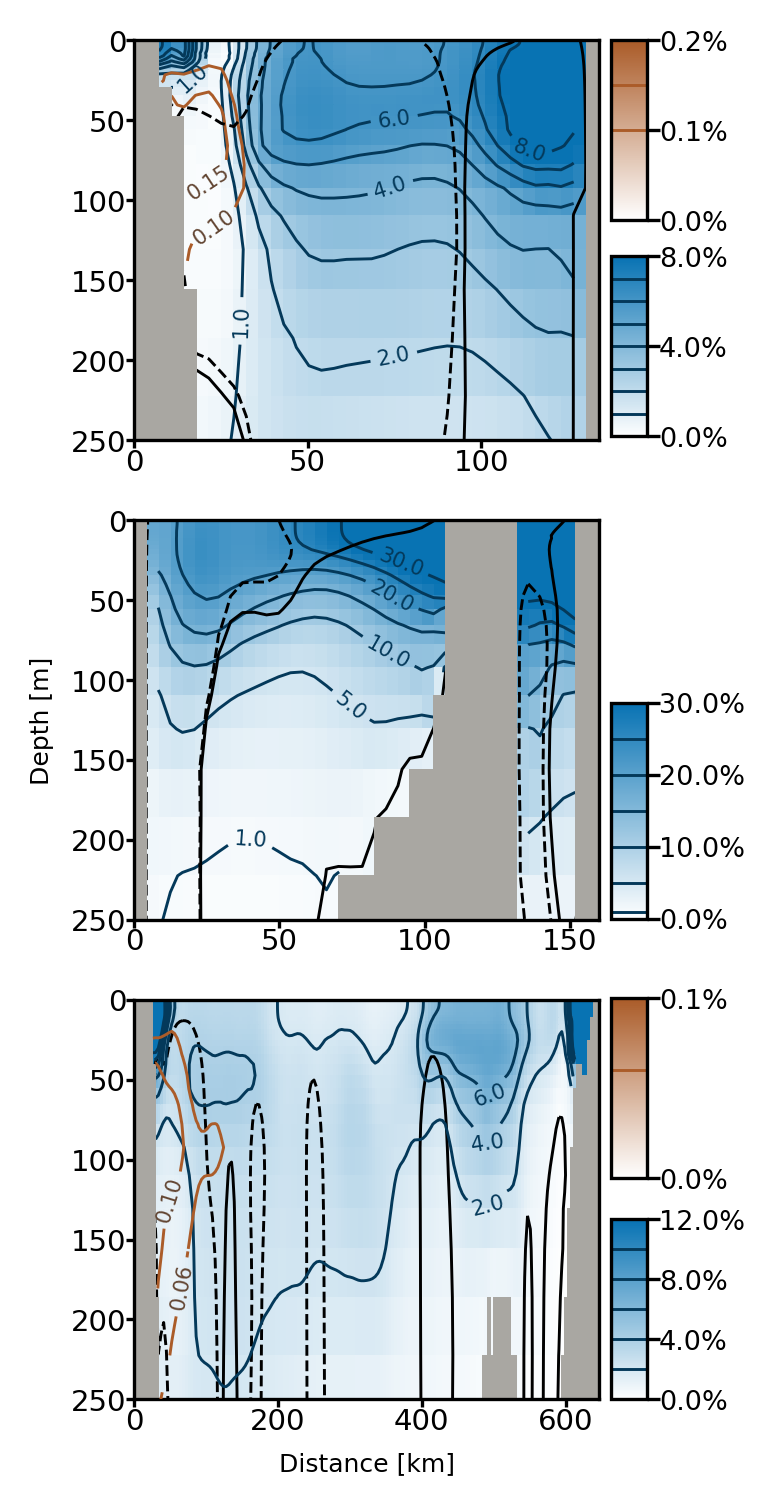

In [97]:
fig, ax = plt.subplots(3,1,figsize=(2, 6), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', labelsize=5)
    axis.set_ylim([250, 0])
    axis.tick_params(axis='both', which='major', pad=-0.1)
    
transect_PC(ax[0], 8)
transect_NS(ax[1], 8)
transect_BB(ax[2], 8)

ax[2].set_xlabel('Distance [km]', fontsize=6)
ax[1].set_ylabel('Depth [m]', fontsize=6)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R1-cross-section.png', bbox_inches='tight', dpi=300)

In [21]:
def transect_PC2(axis, month):
    
    vmin_cont = 0; vmax_cont = 0.4;
    vmin_glac = 0; vmax_glac = 0.8;

    # Coloured in contours for river Mn:
    CS1 = axis.pcolormesh(distance_PC2, depth, np.transpose(ma_cont_xs_low[month,:,P2i,P2j]), \
                        vmin=vmin_cont, vmax=vmax_cont, cmap=cont_cmap)
    CS2 = axis.pcolormesh(distance_PC2, depth, np.transpose(ma_glac_xs_low[month,:,P2i,P2j]), \
                        vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

    # Contour lines for river Mn:
    glac_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    cont_levels = [0.1, 0.2, 0.3]
    glac = axis.contour(distance_PC2, depth, np.transpose(ma_glac_xs_low[month,:,P2i,P2j]), \
               levels=glac_levels, colors='#04395a', linewidths=0.7)
    cont = axis.contour(distance_PC2, depth, np.transpose(ma_cont_xs_low[month,:,P2i,P2j]), \
               levels=cont_levels, colors='#ab5c29', linewidths=0.7)
    
    # Colour bars + figure features:
    cb1axes = fig.add_axes([0.80, 0.34, 0.035, 0.14]) 
    cb2axes = fig.add_axes([0.80, 0.15, 0.035, 0.14]) 
    CBar1 = fig.colorbar(CS1, cax=cb1axes, ticks=[0,0.2,0.4])
    CBar2 = fig.colorbar(CS2, cax=cb2axes, ticks=[0,0.4,0.8])
    CBar1.add_lines(cont)
    CBar2.add_lines(glac)
    for CBar in [CBar1, CBar2]:
        CBar.ax.tick_params(axis='y', length=3, labelsize=6.5, pad=-0.1)
        CBar.ax.set_yticklabels([f'{i:.1f}%' for i in CBar.get_ticks()])
        
    axis.tick_params(axis='both', labelsize=7, length=2)

    manual_locations_glac = [(28, 10), (32, 30), (37, 37), (44, 45), (50, 50)]
    manual_locations_cont = [(12, 70), (13, 25), (27, 25)]
    axis.clabel(glac, [0.1, 0.2, 0.4, 0.6, 0.8], inline=1, fontsize=5, manual=manual_locations_glac, fmt='%.1f')
    axis.clabel(cont, [0.1, 0.2, 0.3], inline=1, fontsize=5, manual=manual_locations_cont, colors='#624532', fmt='%.1f')
 
    axis.pcolormesh(distance_PC2, depth, land_mask[:,imin+P2i,jmin+P2j], cmap=ListedColormap([land_color]), zorder=2) 
    return

Text(0, 0.5, 'Depth [m]')

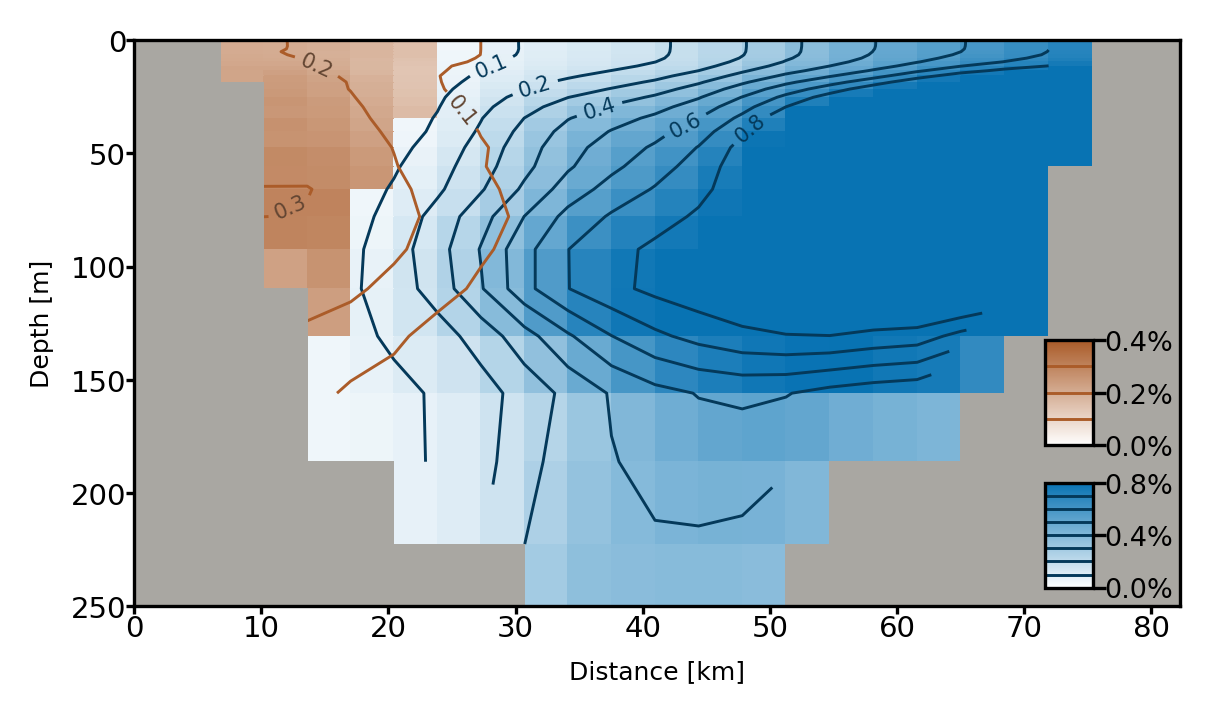

In [18]:
fig, ax = plt.subplots(1,1,figsize=(4.5, 2.5), dpi=300)

ax.invert_yaxis()
ax.set_ylim([250, 0])
ax.tick_params(axis='both', labelsize=5, which='major', pad=-0.1)
    
transect_PC2(ax, 8)

ax.set_xlabel('Distance [km]', fontsize=6)
ax.set_ylabel('Depth [m]', fontsize=6)

# fig.tight_layout(pad=-0.1)